In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy.stats as st
import os
import glob

%matplotlib notebook

In [6]:
main_paths = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220816\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220817\processed",
    
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230123\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230124\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230125\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_636766_20230126\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230130\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230131\processed", 
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_644864_20230201\processed", 
    r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644864_20230202\processed",
    r"\\allen\programs\mindscope\workgroups\np-exp\PilotEphys\Task 2 pilot\DRpilot_644866_20230207\processed", 
    r"Y:\DRpilot_644866_20230208\processed",
    r"Y:\DRpilot_644866_20230209\processed",
    r"Y:\DRpilot_644866_20230210\processed",
    r"Y:\DRpilot_644867_20230220\processed",
    r"Y:\DRpilot_644867_20230221\processed",
    r"Y:\DRpilot_644867_20230222\processed",
    r"Y:\DRpilot_644867_20230223\processed",
    r"Y:\DRpilot_649943_20230213\processed", 
    r"Y:\DRpilot_649943_20230214\processed",
    r"Y:\DRpilot_649943_20230215\processed",
    r"Y:\DRpilot_649943_20230216\processed",   
]


In [26]:
# set paths & load data

mm = main_paths[20]

behav_path=glob.glob(os.path.join(mm,"Behavior_*.npy"))[0]
cam_frames_path = os.path.join(mm,"camera_frames.pkl")
trials_path = os.path.join(mm,"trials_table.csv")

trials=pd.read_csv(trials_path)
behav_info=np.load(behav_path,allow_pickle=True)
with open(cam_frames_path, 'rb') as filepath:
    cam_frames=pickle.load(filepath)


In [27]:
behav_info.item().keys()

dict_keys(['filenames', 'save_path', 'Ly', 'Lx', 'sbin', 'fullSVD', 'save_mat', 'Lybin', 'Lxbin', 'sybin', 'sxbin', 'LYbin', 'LXbin', 'avgframe', 'avgmotion', 'avgframe_reshape', 'avgmotion_reshape', 'motion', 'motSv', 'movSv', 'motMask', 'movMask', 'motMask_reshape', 'movMask_reshape', 'motSVD', 'movSVD', 'pupil', 'running', 'blink', 'rois', 'sy', 'sx'])

In [28]:
behav_info.item()['motion']

[array([11823802., 11823802., 11823802., ..., 11823802., 11823802.,
        11823802.], dtype=float32),
 array([ 7917.,  6801.,  6913., ..., 33702., 19695., 24155.], dtype=float32)]

<IPython.core.display.Javascript object>


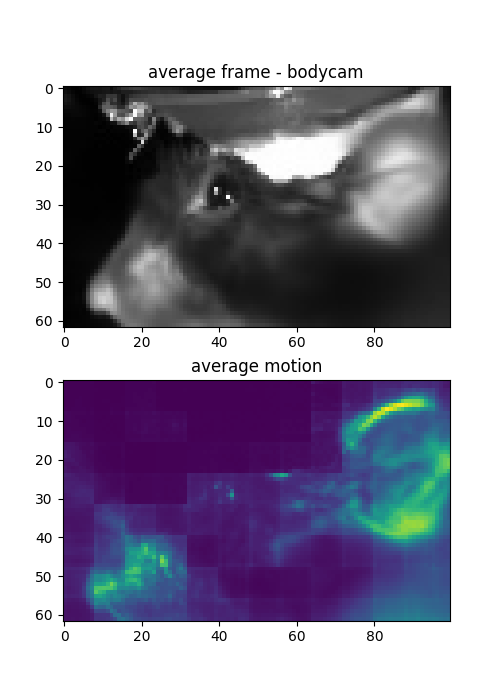

Text(0.5, 1.0, 'average motion')

In [29]:
fig,ax=plt.subplots(2,1,figsize=(5,7))

ax[0].imshow(behav_info.item()['avgframe_reshape'],cmap='gray')
ax[0].set_title('average frame - bodycam')

ax[1].imshow(behav_info.item()['avgmotion_reshape'])
ax[1].set_title('average motion')

In [30]:
# get trial-wise SVD features

# 2 sec before + after stimulus onset
time_before=2
time_after=2
fps=60

behav_SVD_by_trial = np.zeros(((time_before+time_after)*fps,20,len(trials)))
behav_motion_by_trial = np.zeros(((time_before+time_after)*fps,len(trials)))

for tt,stimStartTime in enumerate(trials['stimStartTime']):
    stim_start_frame=np.where(cam_frames['behavior']>=stimStartTime)[0][0]
    trial_start_frame=stim_start_frame-time_before*fps
    trial_end_frame=stim_start_frame+time_before*fps
    
    behav_SVD_by_trial[:,:,tt]=behav_info.item()['motSVD'][1][trial_start_frame:trial_end_frame,:20]    
    behav_motion_by_trial[:,tt] = behav_info.item()['motion'][1][trial_start_frame:trial_end_frame]
    
mean_trial_behav_SVD = np.nanmean(behav_SVD_by_trial,axis=2)
t_points=np.arange(-time_before,time_after,1/fps)


#average within vis vs. aud blocks
#SVD
vis_block_behav_SVD=np.nanmean(behav_SVD_by_trial[:,:,trials['trialstimRewarded']=='vis1'],axis=2)
aud_block_behav_SVD=np.nanmean(behav_SVD_by_trial[:,:,trials['trialstimRewarded']=='sound1'],axis=2)

vis_block_behav_SVD_sem=st.sem(behav_SVD_by_trial[:,:,trials['trialstimRewarded']=='vis1'],
                                  nan_policy='omit',axis=2)
aud_block_behav_SVD_sem=st.sem(behav_SVD_by_trial[:,:,trials['trialstimRewarded']=='sound1'],
                                  nan_policy='omit',axis=2)

#absolute motion
vis_block_behav_motion=np.nanmean(behav_motion_by_trial[:,trials['trialstimRewarded']=='vis1'],axis=1)
aud_block_behav_motion=np.nanmean(behav_motion_by_trial[:,trials['trialstimRewarded']=='sound1'],axis=1)

vis_block_behav_motion_sem=st.sem(behav_motion_by_trial[:,trials['trialstimRewarded']=='vis1'],
                                  nan_policy='omit',axis=1)
aud_block_behav_motion_sem=st.sem(behav_motion_by_trial[:,trials['trialstimRewarded']=='sound1'],
                                  nan_policy='omit',axis=1)

In [31]:
# behav_info.item()['motion']

<IPython.core.display.Javascript object>


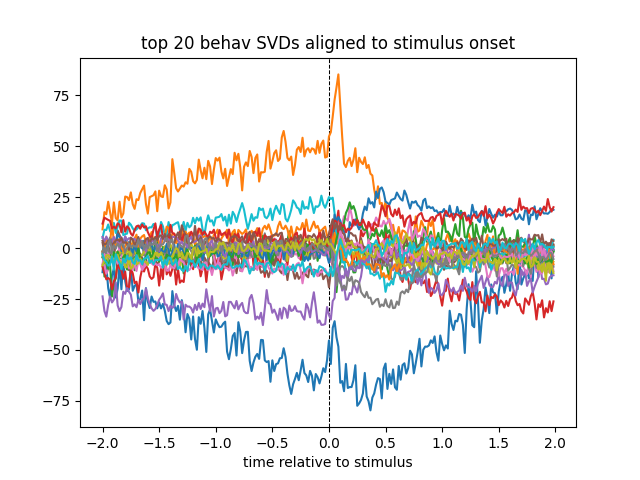

Text(0.5, 1.0, 'top 20 behav SVDs aligned to stimulus onset')

In [32]:
fig,ax=plt.subplots(1,1)
ax.axvline(0,color='k',linewidth=0.75,linestyle='--')
ax.plot(t_points,mean_trial_behav_SVD)
ax.set_xlabel('time relative to stimulus')
ax.set_title('top 20 behav SVDs aligned to stimulus onset')

<IPython.core.display.Javascript object>


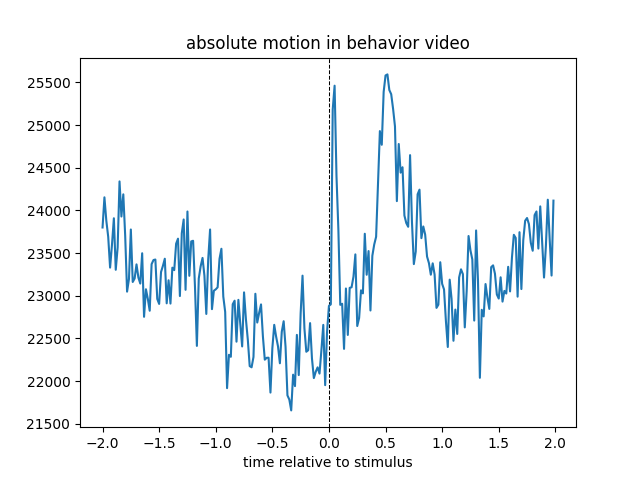

Text(0.5, 1.0, 'absolute motion in behavior video')

In [33]:
fig,ax=plt.subplots(1,1)
ax.axvline(0,color='k',linewidth=0.75,linestyle='--')
ax.plot(t_points,np.mean(behav_motion_by_trial,1))
ax.set_xlabel('time relative to stimulus')
ax.set_title('absolute motion in behavior video')

<IPython.core.display.Javascript object>


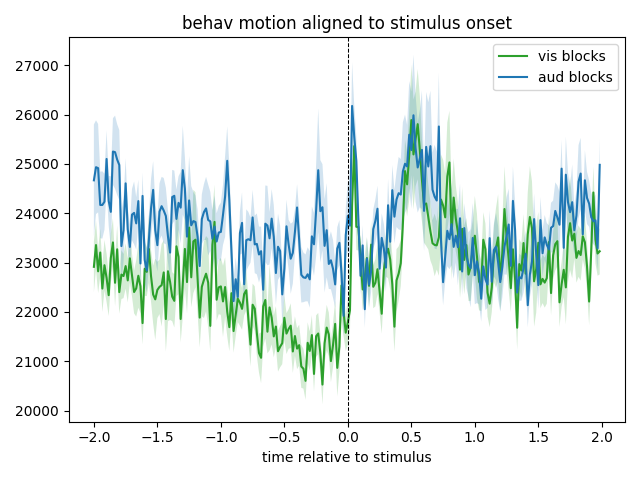

In [34]:
fig,ax=plt.subplots(1,1)

y=vis_block_behav_motion
err=vis_block_behav_motion_sem
ax.plot(t_points, y, 'tab:green')
plt.fill_between(t_points, y-err, y+err,
    alpha=0.2, edgecolor=None, facecolor='tab:green')

y=aud_block_behav_motion
err=aud_block_behav_motion_sem
ax.plot(t_points, y, 'tab:blue')
plt.fill_between(t_points, y-err, y+err,
    alpha=0.2, edgecolor=None, facecolor='tab:blue')

# ax.plot(t_points,aud_block_behav_motion,'tab:blue')


ax.legend(['vis blocks','aud blocks'])
ax.axvline(0,color='k',linewidth=0.75,linestyle='--')
ax.set_xlabel('time relative to stimulus')
ax.set_title('behav motion aligned to stimulus onset')

fig.tight_layout()

<IPython.core.display.Javascript object>


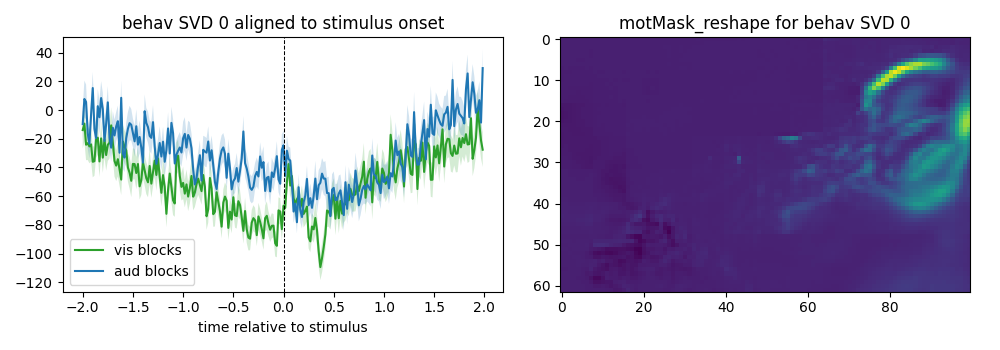

<IPython.core.display.Javascript object>


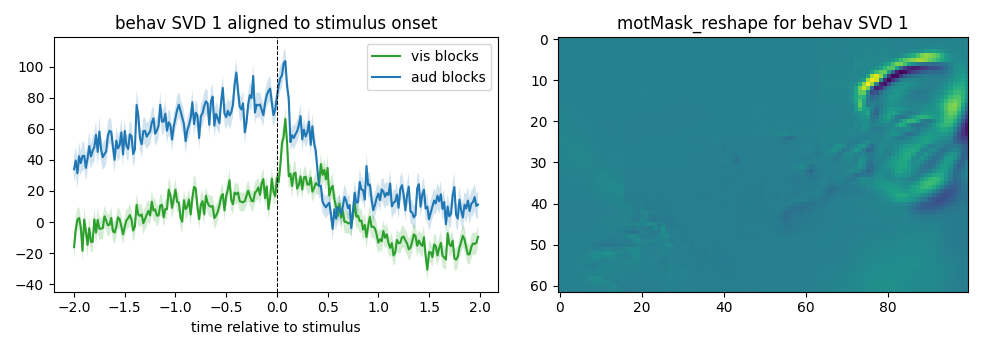

<IPython.core.display.Javascript object>


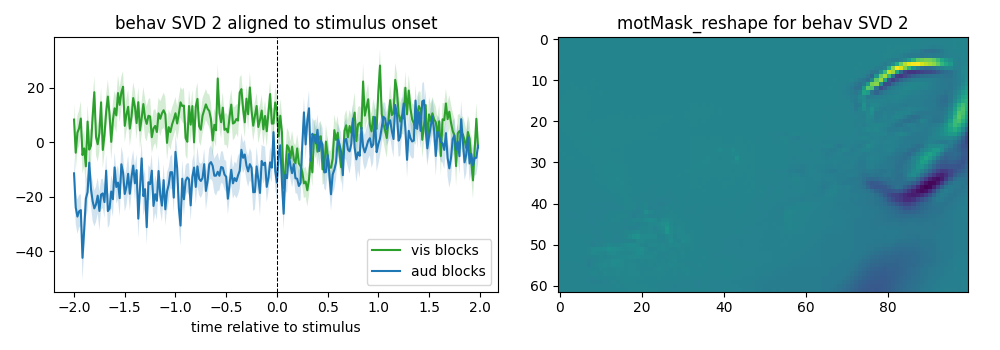

<IPython.core.display.Javascript object>


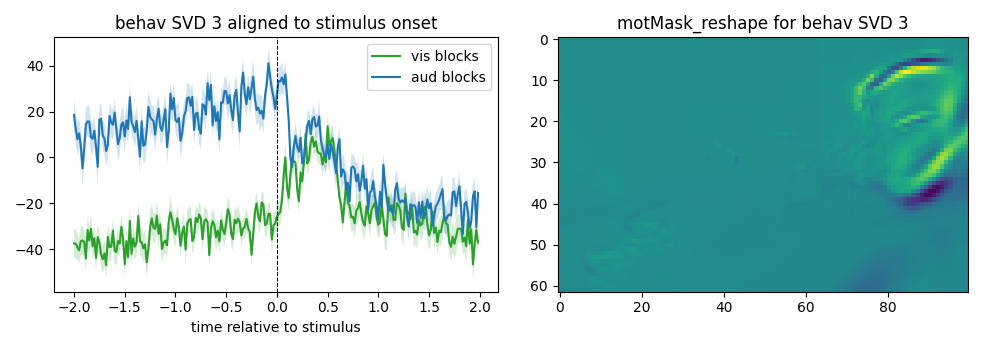

<IPython.core.display.Javascript object>


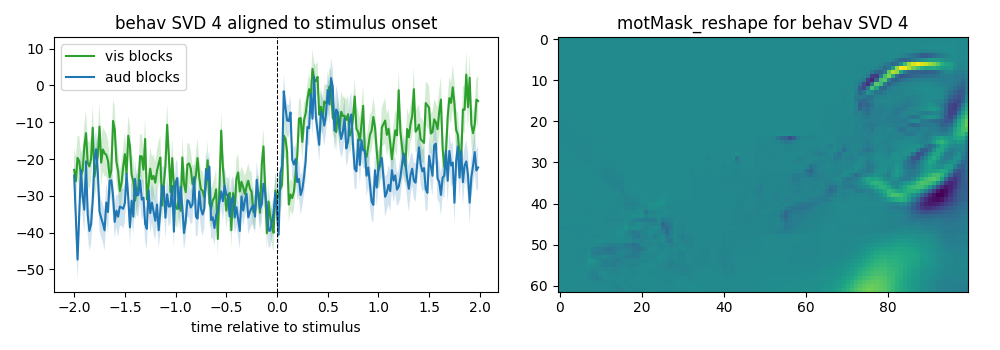

<IPython.core.display.Javascript object>


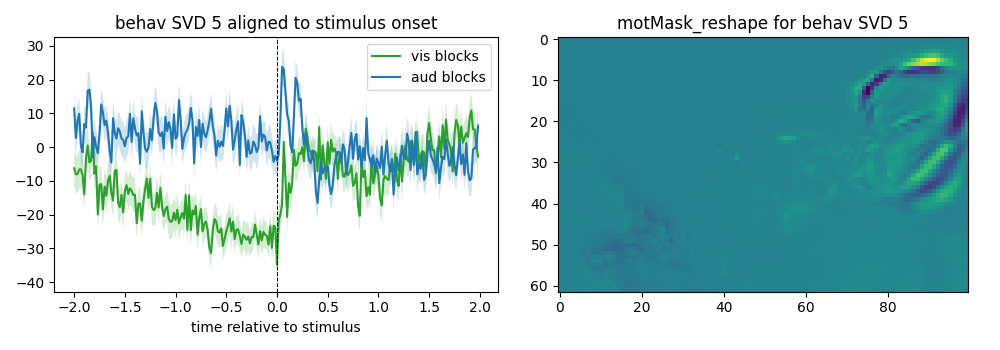

<IPython.core.display.Javascript object>


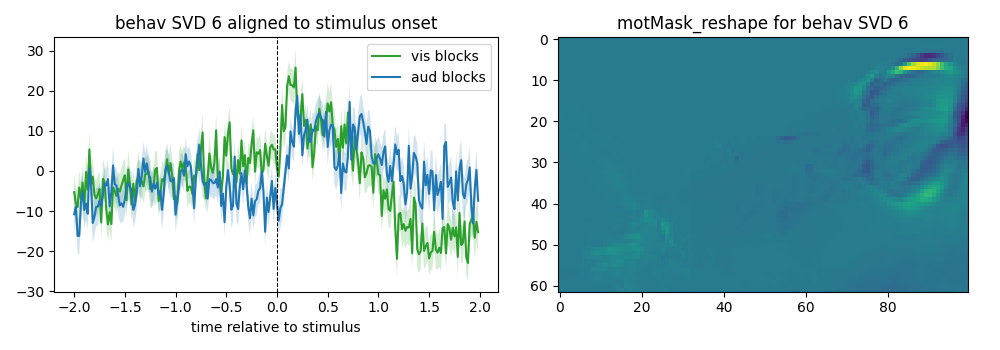

<IPython.core.display.Javascript object>


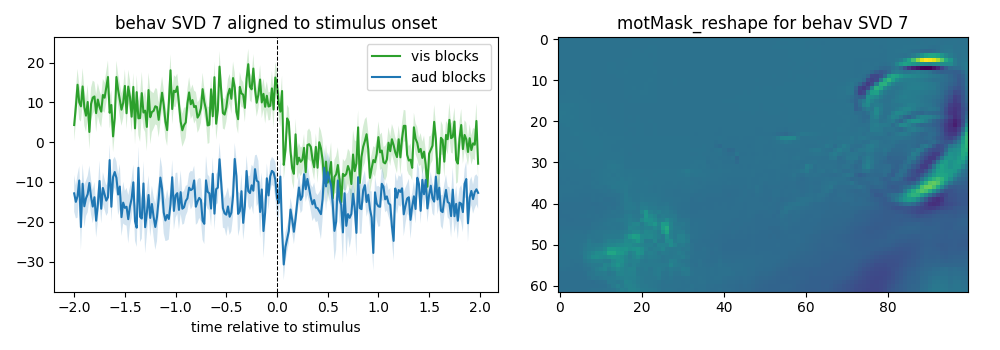

<IPython.core.display.Javascript object>


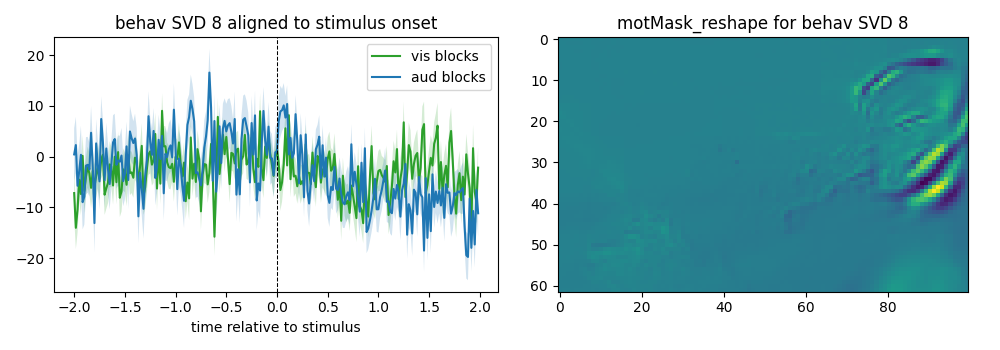

<IPython.core.display.Javascript object>


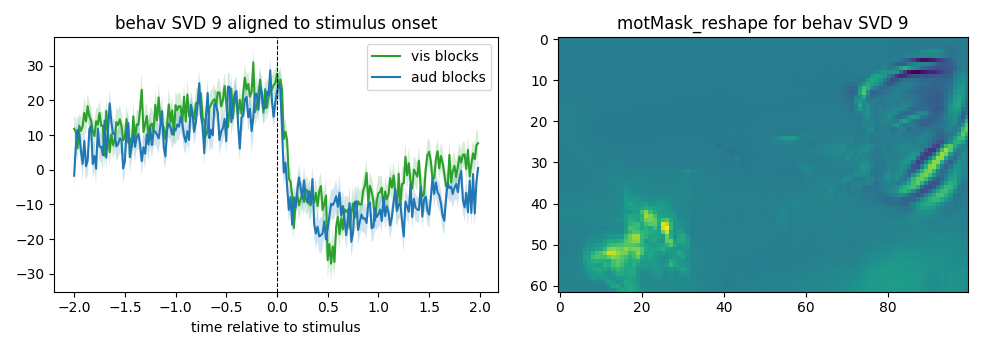

<IPython.core.display.Javascript object>


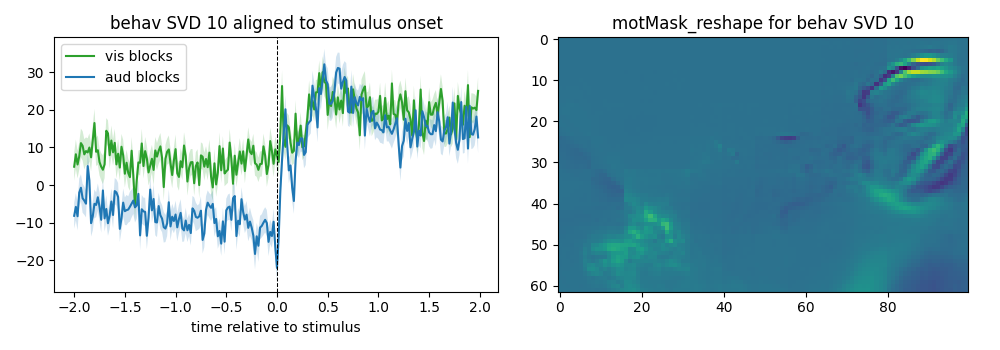

<IPython.core.display.Javascript object>


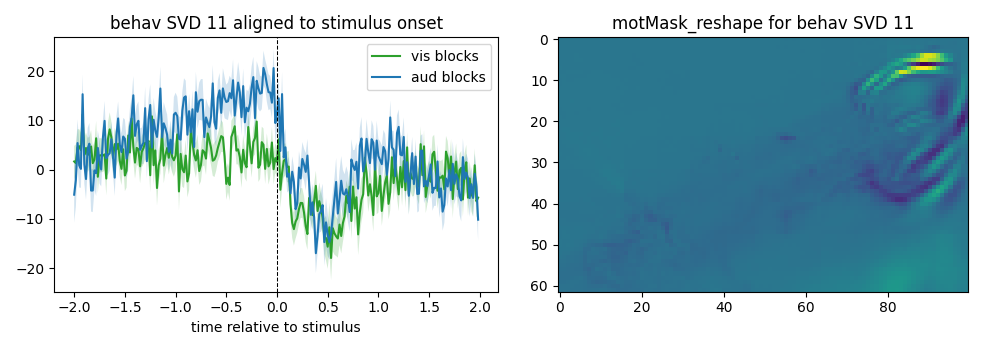

<IPython.core.display.Javascript object>


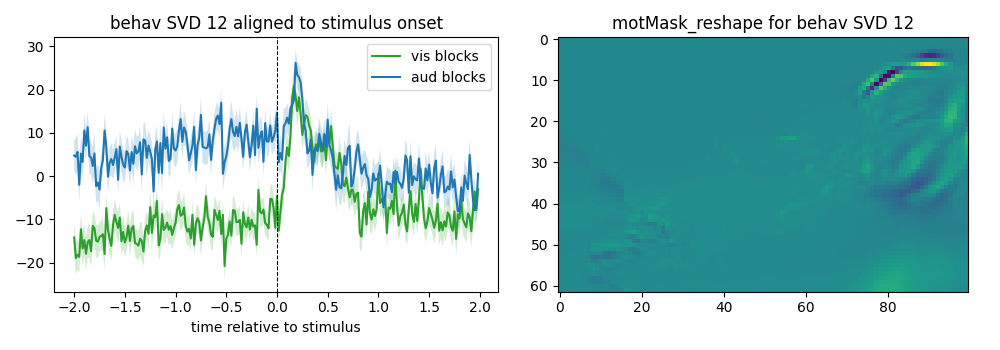

<IPython.core.display.Javascript object>


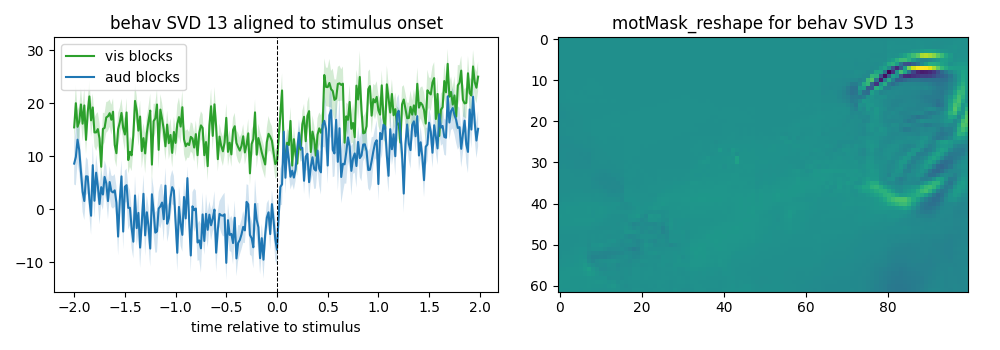

<IPython.core.display.Javascript object>


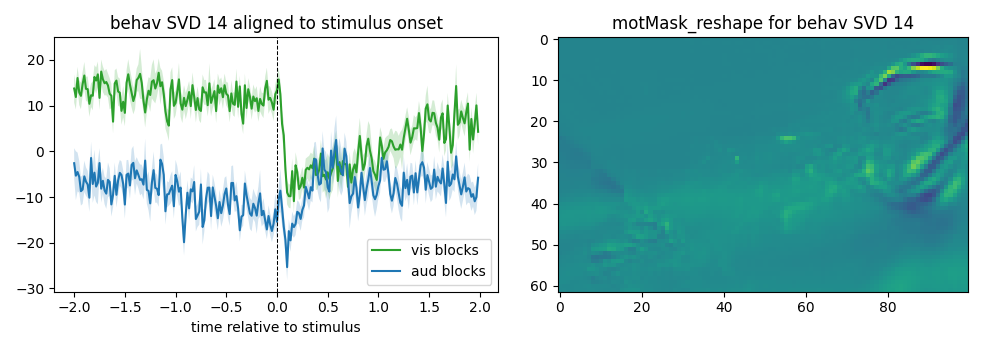

<IPython.core.display.Javascript object>


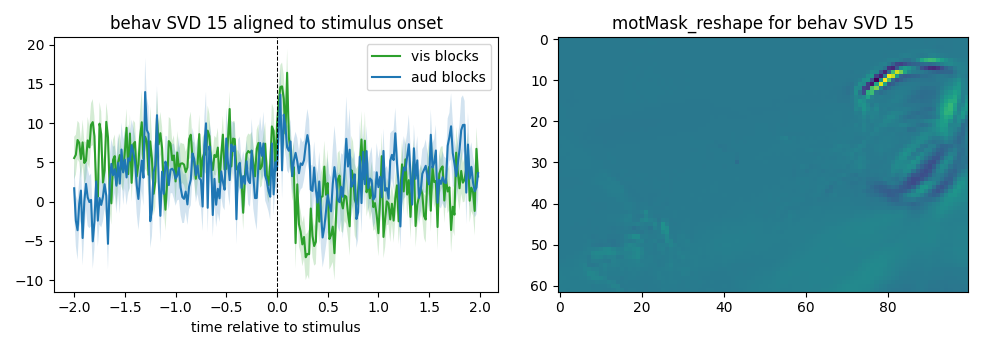

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_39340\2465050555.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax=plt.subplots(1,2,figsize=(10,3.5))


<IPython.core.display.Javascript object>


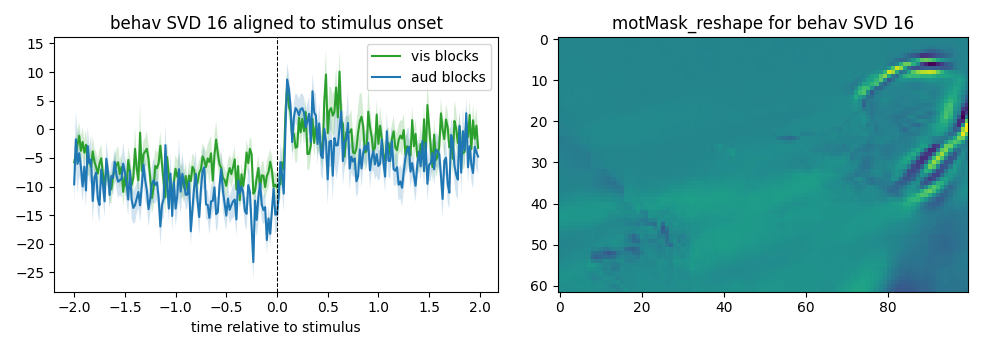

<IPython.core.display.Javascript object>


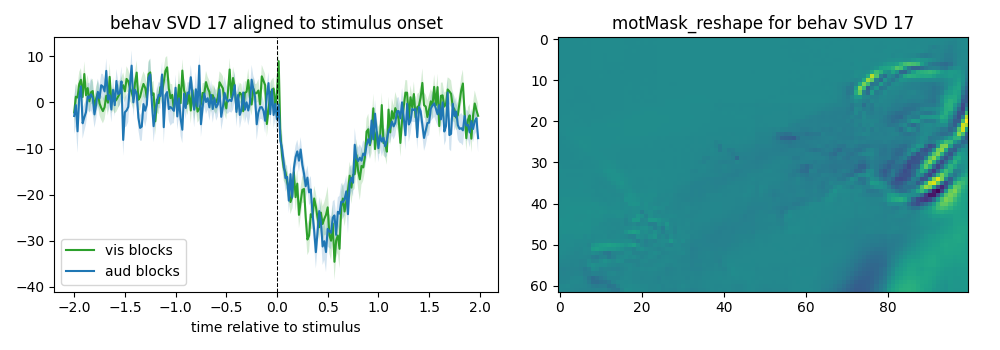

<IPython.core.display.Javascript object>


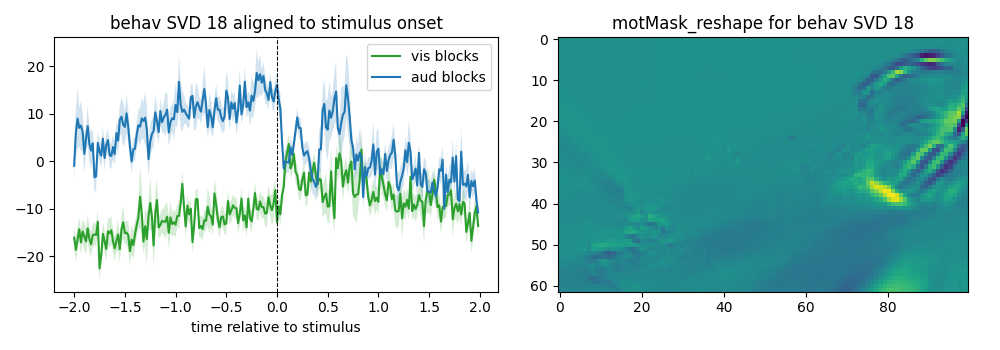

<IPython.core.display.Javascript object>


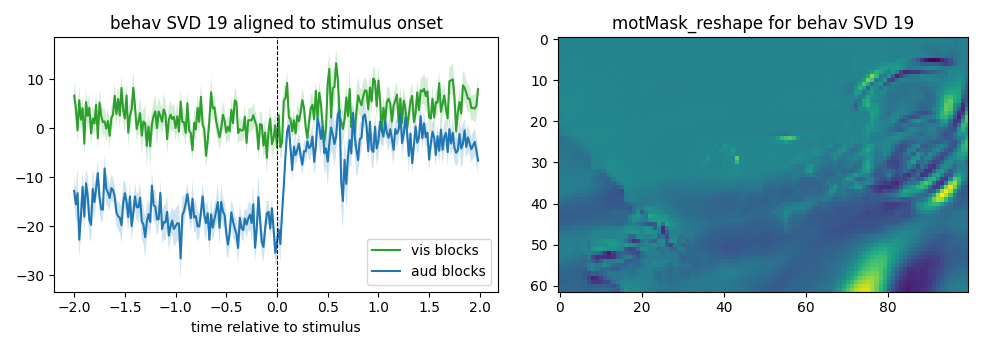

In [35]:
sel_feature=0

for sel_feature in range(0,20):

    fig,ax=plt.subplots(1,2,figsize=(10,3.5))

    y=vis_block_behav_SVD[:,sel_feature]
    err=vis_block_behav_SVD_sem[:,sel_feature]
    ax[0].plot(t_points, y, 'tab:green')
    ax[0].fill_between(t_points, y-err, y+err,
        alpha=0.2, edgecolor=None, facecolor='tab:green')

    y=aud_block_behav_SVD[:,sel_feature]
    err=aud_block_behav_SVD_sem[:,sel_feature]
    ax[0].plot(t_points, y, 'tab:blue')
    ax[0].fill_between(t_points, y-err, y+err,
        alpha=0.2, edgecolor=None, facecolor='tab:blue')

    # ax[0].plot(t_points,vis_block_behav_SVD[:,sel_feature],'tab:green')
    # ax[0].plot(t_points,aud_block_behav_SVD[:,sel_feature],'tab:blue')
    ax[0].legend(['vis blocks','aud blocks'])
    ax[0].axvline(0,color='k',linewidth=0.75,linestyle='--')
    ax[0].set_xlabel('time relative to stimulus')
    ax[0].set_title('behav SVD '+str(sel_feature)+' aligned to stimulus onset')


    ax[1].imshow(behav_info.item()['motMask_reshape'][0][:,:,sel_feature])
    ax[1].set_title('motMask_reshape for behav SVD '+str(sel_feature))
    fig.tight_layout()

#     figname='behav_SVD_'+str(sel_feature)+'.png'
#     plt.savefig(os.path.join(fig_save_path,figname), dpi=300, facecolor='w', edgecolor='w',
#                 orientation='portrait', format='png', transparent=True, bbox_inches='tight', 
#                 pad_inches=0.1, metadata=None)
